In [1]:
import requests
import io
import datetime

import numpy as np
import pandas as pd
import matplotlib.pylab as plt
# plt.rcParams["figure.figsize"] = (8, 6)

In [2]:
import lightgbm as lgb
from statsmodels.stats.diagnostic import acorr_ljungbox
import statsmodels.api as sm
from scipy import stats

In [3]:
INPUT_DIR = "input/"

In [4]:
valid_start = datetime.datetime(2019, 1, 1)
pred_start = datetime.datetime(2020, 1, 1)
pred_end = datetime.datetime(2021, 1, 1)

In [5]:
def plot_prediction(df_eval):
    actual = df_eval['y']
    pred = df_eval['pred']
    
    mape = (np.abs(pred - actual) / actual * 100).mean()

    actual.plot(label='actual')
    pred.plot(label=f'predict, MAPE:{mape:.2f} %')
    plt.legend()
    plt.show()
    
    (pred - actual).plot(label='residual')
    plt.legend()
    plt.show()

In [6]:
def correlation_plot(data, lags=60):
    fig = plt.figure(figsize=(10, 8))
    # 自己相関のコレログラム
    ax1 = fig.add_subplot(2, 1, 1)
    ax1.set_ylim(-1.1, 1.1)
    fig = sm.graphics.tsa.plot_acf(data, lags=lags, ax=ax1)
    # 偏自己相関のコレログラム
    ax2 = fig.add_subplot(2, 1, 2)
    ax2.set_ylim(-1.1, 1.1)    
    fig = sm.graphics.tsa.plot_pacf(data, lags=lags, ax=ax2)
    plt.show()

In [7]:
target = ['y']
features = []

df = pd.read_csv(INPUT_DIR + 'daily.csv')
df['ds'] = pd.to_datetime(df['date'])
df['y'] = df['power']

df_temperature = pd.read_csv(INPUT_DIR + 'daily_temperature.csv')
df_temperature['ds'] = pd.to_datetime(df_temperature['date'])
features.append('temperature')

df_gdp = pd.read_csv(INPUT_DIR + 'daily_gdp.csv')
df_gdp['ds'] = pd.to_datetime(df_gdp['date'])
features.append('gdp')

df = pd.merge(df[['ds', 'y']], df_temperature[['ds', 'temperature']], on='ds', how='left')
df = pd.merge(df, df_gdp[['ds', 'gdp']], on='ds', how='left')

df['week'] = df['ds'].dt.isocalendar().week.astype('int')
features.append('week')
df['dayofweek'] = df['ds'].dt.dayofweek
features.append('dayofweek')

for l in range(2,15):
    df[f'y_shift_{l}d'] = df['y'].shift(l).bfill()
    df[f't_shift_{l}d'] = df['temperature'].shift(l).bfill()
    features.append(f'y_shift_{l}d')
    features.append(f't_shift_{l}d')

In [8]:
df_train = df[(df['ds'] < valid_start)]
df_valid = df[(df['ds'] < pred_start) & (df['ds'] >= valid_start)]
df_test = df[(df['ds']>= pred_start) & (df['ds'] < pred_end)]

In [9]:
lgb_train = lgb.Dataset(df_train[features], df_train[target])
lgb_valid = lgb.Dataset(df_valid[features], df_valid[target])
lgb_test = lgb.Dataset(df_test[features], df_test[target])
# 評価基準を設定する 
params = {'metric' : 'rmse'}

In [10]:
model = lgb.train(params = params,
                  train_set = lgb_train,
                  num_boost_round = 1000,
                  valid_sets =lgb_valid,
                  verbose_eval=10,
                  early_stopping_rounds = 10
                 )

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000388 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6803
[LightGBM] [Info] Number of data points in the train set: 1005, number of used features: 30
[LightGBM] [Info] Start training from score 32.543366
Training until validation scores don't improve for 10 rounds
[10]	valid_0's rmse: 2.23583
[20]	valid_0's rmse: 1.63401
[30]	valid_0's rmse: 1.44952
[40]	valid_0's rmse: 1.37813
[50]	valid_0's rmse: 1.33973
[60]	valid_0's rmse: 1.3224
[70]	valid_0's rmse: 1.30436
[80]	valid_0's rmse: 1.29537
[90]	valid_0's rmse: 1.28616
[100]	valid_0's rmse: 1.27968
[110]	valid_0's rmse: 1.27278
[120]	valid_0's rmse: 1.26616
[130]	valid_0's rmse: 1.26287
[140]	valid_0's rmse: 1.26207
[150]	valid_0's rmse: 1.26069
[160]	valid_0's rmse: 1.2593
[170]	valid_0's rmse: 1.25937
Early stopping, best iteration is:
[162]	valid_0's rmse: 1.25844


In [11]:
eval_cols = target + ['ds']
df_eval = df_test[eval_cols].copy()
df_eval['pred'] = model.predict(df_test[features])
df_eval = df_eval.set_index('ds')

In [12]:
df_eval

,y,pred
ds,,
2020-01-01,27.447500,32.128237
2020-01-02,27.917917,31.296495
2020-01-03,28.255000,31.892033
2020-01-04,29.801667,29.129164
2020-01-05,31.040000,29.290392
...,...,...
2020-12-27,31.651250,31.196557
2020-12-28,32.922500,35.020749
2020-12-29,31.521250,36.499540


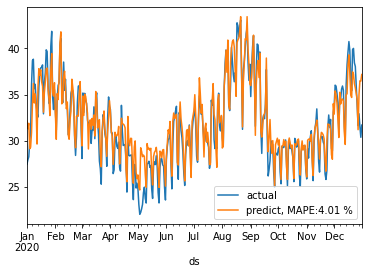

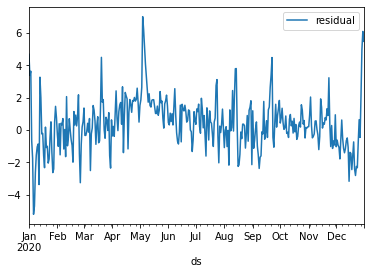

In [13]:
plot_prediction(df_eval)

## 残差の確認

Jack Bera: 	 Jarque_beraResult(statistic=72.85297919206032, pvalue=1.1102230246251565e-16)


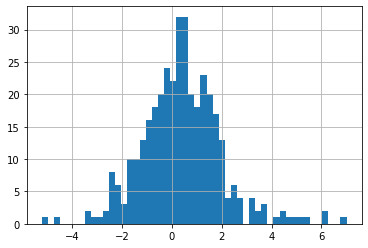

In [14]:
diff_arr = df_eval['pred'] - df_eval['y']

diff_arr.hist(bins=50)

jarque_bera_test = stats.jarque_bera(diff_arr)
print('Jack Bera:', '\t', jarque_bera_test)

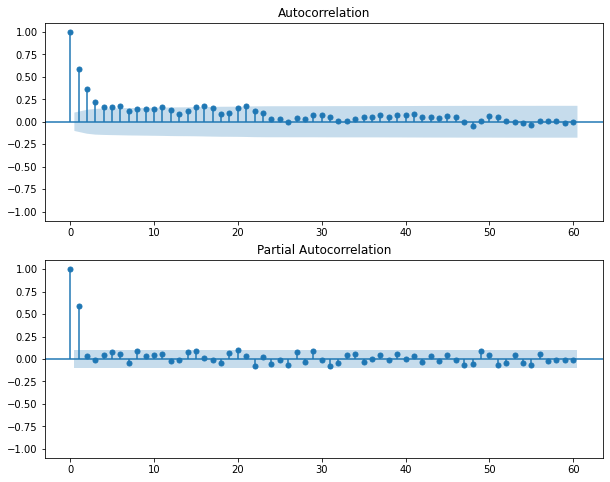

1 126.79600683283432 2.0588472465098407e-29
2 176.25366308545208 5.3333901361428346e-39
3 194.48013221365716 6.573091576732857e-42
4 204.32865099654455 4.406834408943913e-43
5 214.1897951573515 2.6083293544124075e-44
6 225.13342605347887 8.363796835114356e-46
7 230.2914594833585 4.303654512377972e-46
8 237.6045630044325 7.280479687445983e-47
9 244.67192395924553 1.3288087078653728e-47
10 252.51200998930003 1.6083412523477886e-48


/home/ryoji/.cache/pypoetry/virtualenvs/timeseries-weK0nu0g-py3.8/lib/python3.8/site-packages/statsmodels/stats/diagnostic.py:559: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)


In [15]:
correlation_plot(diff_arr)

results = acorr_ljungbox(diff_arr, lags=10)
lag = 1
for lb, p in zip(results[0], results[1]):
    print(lag, lb, p)
    lag += 1

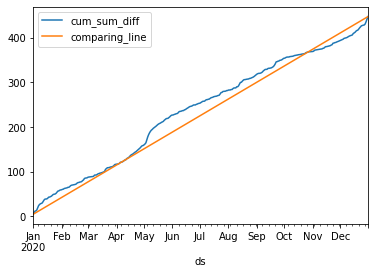

In [16]:
cum_arr = diff_arr.apply(np.abs).cumsum()

cum_min = cum_arr.min()
cum_max = cum_arr.max()

se_line = pd.Series(np.linspace(cum_min, cum_max, len(diff_arr)), index=diff_arr.index)

cum_arr.plot(label='cum_sum_diff')
se_line.plot(label='comparing_line')
plt.legend()
plt.show()

---ctt---
(-9.925597487032832, 6.849878514545357e-15, 0, 365, {'1%': -4.4031542236611765, '5%': -3.84866618364236, '10%': -3.5633273382191524}, 1121.851685173679)
---ct---
(-9.389412700231716, 4.8744894671577286e-14, 0, 365, {'1%': -3.983789155923777, '5%': -3.422587251359195, '10%': -3.1341637572908128}, 1124.096179387136)
---c---
(-9.421965920416035, 5.47261602968775e-16, 0, 365, {'1%': -3.4483935212959844, '5%': -2.8694912343676497, '10%': -2.571005879151811}, 1122.6209263611822)
---nc---
(-4.179589707412479, 3.572207373938121e-05, 5, 360, {'1%': -2.5719785416666667, '5%': -1.9417714064000344, '10%': -1.6161026199417008}, 1126.4311055936578)


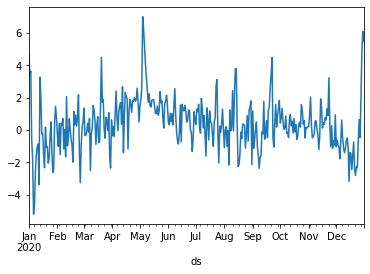

In [17]:
y = diff_arr
y.plot()
regs = ['ctt', 'ct', 'c', 'nc'] # 2次のトレンド＋定数項、1次のトレンド＋定数項, トレンドなし＋定数項、トレンド・定数項なし
for r in regs:
    print(f'---{r}---')
    print(sm.tsa.stattools.adfuller(y, regression=r))

##  特徴量重要度

In [18]:
importances = pd.DataFrame(model.feature_importance('gain'), index=features, columns=['gain'])
importances['split'] = model.feature_importance('split')

In [19]:
importances['gain'].sort_values(ascending=False)

y_shift_7d     25576.431228
temperature    25056.640315
y_shift_2d     18227.792384
dayofweek      11388.610627
y_shift_14d     3301.174383
week            1769.177579
y_shift_4d      1442.043062
y_shift_5d       450.204894
y_shift_3d       449.435235
t_shift_5d       411.344711
y_shift_9d       387.237930
y_shift_8d       371.625907
t_shift_2d       326.073072
y_shift_10d      304.207666
y_shift_6d       273.742489
t_shift_3d       249.251167
t_shift_10d      230.730722
y_shift_11d      228.335088
y_shift_13d      223.699903
t_shift_7d       215.443674
t_shift_8d       203.931852
t_shift_4d       203.668860
t_shift_9d       202.230201
t_shift_14d      193.620632
t_shift_11d      184.474349
t_shift_6d       160.987941
t_shift_13d      152.717950
t_shift_12d      140.427093
y_shift_12d      135.310201
gdp              133.785919
Name: gain, dtype: float64